# Module Description

MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a [Creative Commons Attribution-Share Alike 3.0](https://creativecommons.org/licenses/by-sa/3.0/) license.

## Table of Contents
- [Module Description](#Module-Description)
    - [Packages' Installation](#Packages'-Installation)
    - [Const Variables Declaraion](#Const-Variables-Declaraion)
    - [Global Functions Declaration](#Global-Functions-Declaration)
    - [Data Upload](#Data-Upload)
    - [Data Evaluation](#Data-Evaluation)
        - [First look](#First-look)
        - [Nan Values](#Nan-Values)
    - [Models building](#Models-building)
        - [Data Split](#Data-Split)
        - [Multinomial Logistic Regression](#Multinomial-Logistic-Regression)
        - [One Layer Neural Network](#One-Layer-Neural-Network)
        - [Data Normalization](#Data-Normalization)
            - [One hot encoding](#One-hot-encoding)
        - [Two layers Deep Neural Network](#Two-layers-Deep-Neural-Network)
            - [Loss function](#Loss-function)
            - [Weights' optimization](#Weights'-optimization)
            - [Metrics](#Metrics)
        - [Convolutional Neural Network](#Convolutional-Neural-Network)

## Packages' Installation

* **[ggplot2](https://ggplot2.tidyverse.org/)** - the package for the data portroyal
* **[repr](https://cran.r-project.org/web/packages/repr/index.html)** - specify an object and a format to represent it in.

In [2]:
library(ggplot2)
library(repr)
library(scales)
library(dplyr)
library(caret)
library(nnet)
library(reshape2)
library(gridExtra)
library(tensorflow)
library(keras)
library(tfruns)
library(tfestimators)

## Const Variables Declaraion

- **theme_settings** - define the settings for figure

- **ubyte_data** - The data from the [MNIST database](http://yann.lecun.com/exdb/mnist/index.html) differs from the Kaggle's data. Thus I've implemented two options of data reading. Apparently, I was using `csv` reading, however if you'd like so, you may load the `ubyte` by setting `ubyte_data` as `TRUE`.

- **label_index** - MNIST labels store in the distinct files, therefore I add them up as a unique field (column) to the appropriate dataset. However the Kaggl's data contains the label as the first element. I do change this variable depends on which dataset I use.

In [3]:
theme_settings <- theme(axis.text=element_text(size=14),
        axis.title=element_text(size=16),
        legend.title=element_text(size=16),
        legend.text=element_text(size=16))

ubyte_data <- FALSE

label_index <- 1

## Global Functions Declaration

In [4]:
if (ubyte_data){
    # load image files
    load_image_file <- function(filename) {
      ret = list()
      f = file(filename, 'rb')
      readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
      close(f)
      data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
    }

    # load label files
    load_label_file <- function(filename) {
      f = file(filename, 'rb')
      readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
      y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
      close(f)
      y
    }
    
    label_index <- 785
}

# helper function for visualization
show_digit = function(arr784, col = gray(12:1 / 12), label=TRUE, ...) {
    if (label){
            arr784 <- arr784[-label_index]
        }
  image(matrix(as.matrix(arr784), nrow = 28)[, 28:1], col = col, ...)
}

# helper function for confusion matrix vizualization
confusion_matrix <- function(predicted, real){
    melt_table <- melt(table(real, predicted))    
    ggplot(melt_table, aes(x=real, y=predicted, fill=value)) + geom_tile(color = "black") +
    geom_text(aes(real, predicted, label = value), color = "black", size = 4) +
    scale_fill_gradient2(high = "red", mid = "white", space = "Lab", name="Number of\nfitted digits") +
    theme_minimal()+ # minimal theme
    theme(axis.text.y = element_text(angle = 90, vjust = -10, size = 10), 
       axis.text.x = element_text(vjust = 10, size = 10), 
       plot.title = element_text(hjust = 0.5),
       panel.grid.major = element_blank(),
       panel.grid.minor = element_blank(),
       panel.border = element_blank(),
       panel.background = element_blank()) +
    labs(title = "Confusion Matrix", x = "True Value", y = "Predicted Value") +
    coord_fixed() +
    scale_x_continuous(breaks = seq(0, 9, by = 1)) + 
    scale_y_continuous(breaks = seq(0, 9, by = 1))
}

## Data Upload

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:

```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

```
ImageId,Label
1,3
2,7
3,8 
(27997 more lines)
```

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.

In [5]:
if (ubyte_data) {
    # load images
    train <- load_image_file("data/train-images.idx3-ubyte")
    train$label = as.factor(load_label_file("data/train-labels.idx1-ubyte"))

    # load labels
    test  <- load_image_file("data/t10k-images.idx3-ubyte")
    test$label  = as.factor(load_label_file("data/t10k-labels.idx1-ubyte"))
} else {
    train <- read.csv('data/train.csv')
    test <- read.csv('data/test.csv')
}

The data looks like:

In [6]:
head(train)

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


A row spited onto 28x28 pixels looks like:

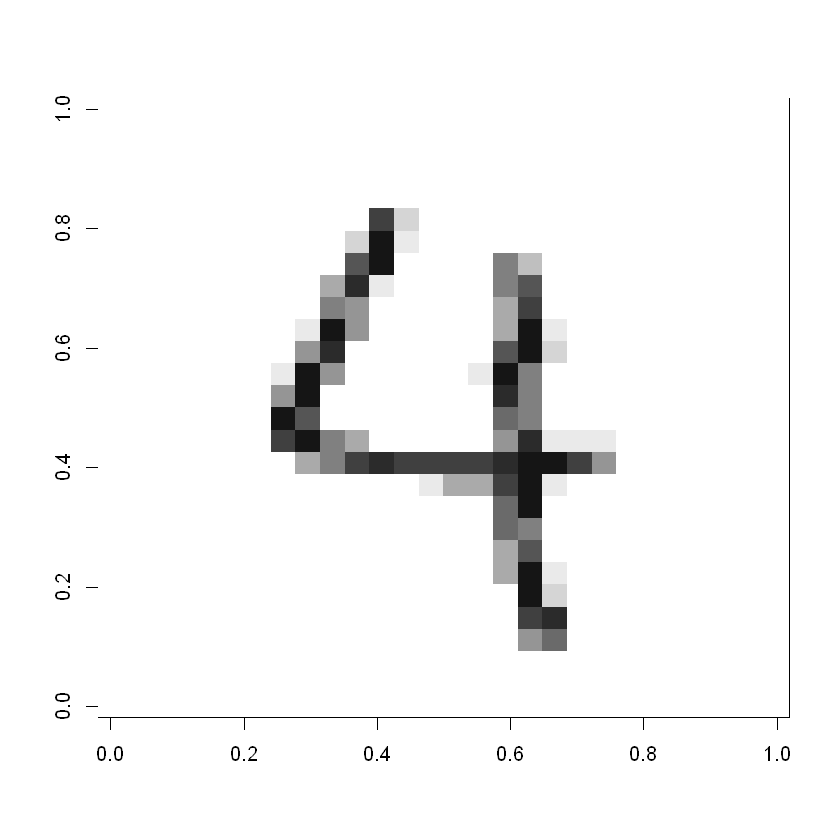

In [7]:
show_digit(train[1000,])

## Data Evaluation

Set the `label` as [factor varible](https://stats.idre.ucla.edu/r/modules/factor-variables/). 

In [7]:
is.factor(train$label)

[1] FALSE

In [6]:
train$label <- as.factor(train$label)
is.factor(train$label)

[1] TRUE

### First look

Create new table 10x2:
- 1 - **digit** contains unique digit in range [0;9]
- 2 - **amount** the quantity of these digits

In [10]:
tbl <- data.frame(with(train, table(train$label)))
colnames(tbl) <- c('digit', 'amount')

Take a look the data distribution in the train data. 
The amount of every single digit is pretty equal. It approaches to the 10% of each one. It will help us select the right metric to evaluate a model.

In [11]:
barplot <- ggplot(tbl, aes(x=digit, y=amount, fill=digit)) +
  geom_bar(stat="identity") + 
  geom_text(aes(label = scales::percent((amount)/sum(amount))), position = position_stack(vjust = 0.9), size = 6) + theme_settings
options(repr.plot.width=16,repr.plot.height=6)

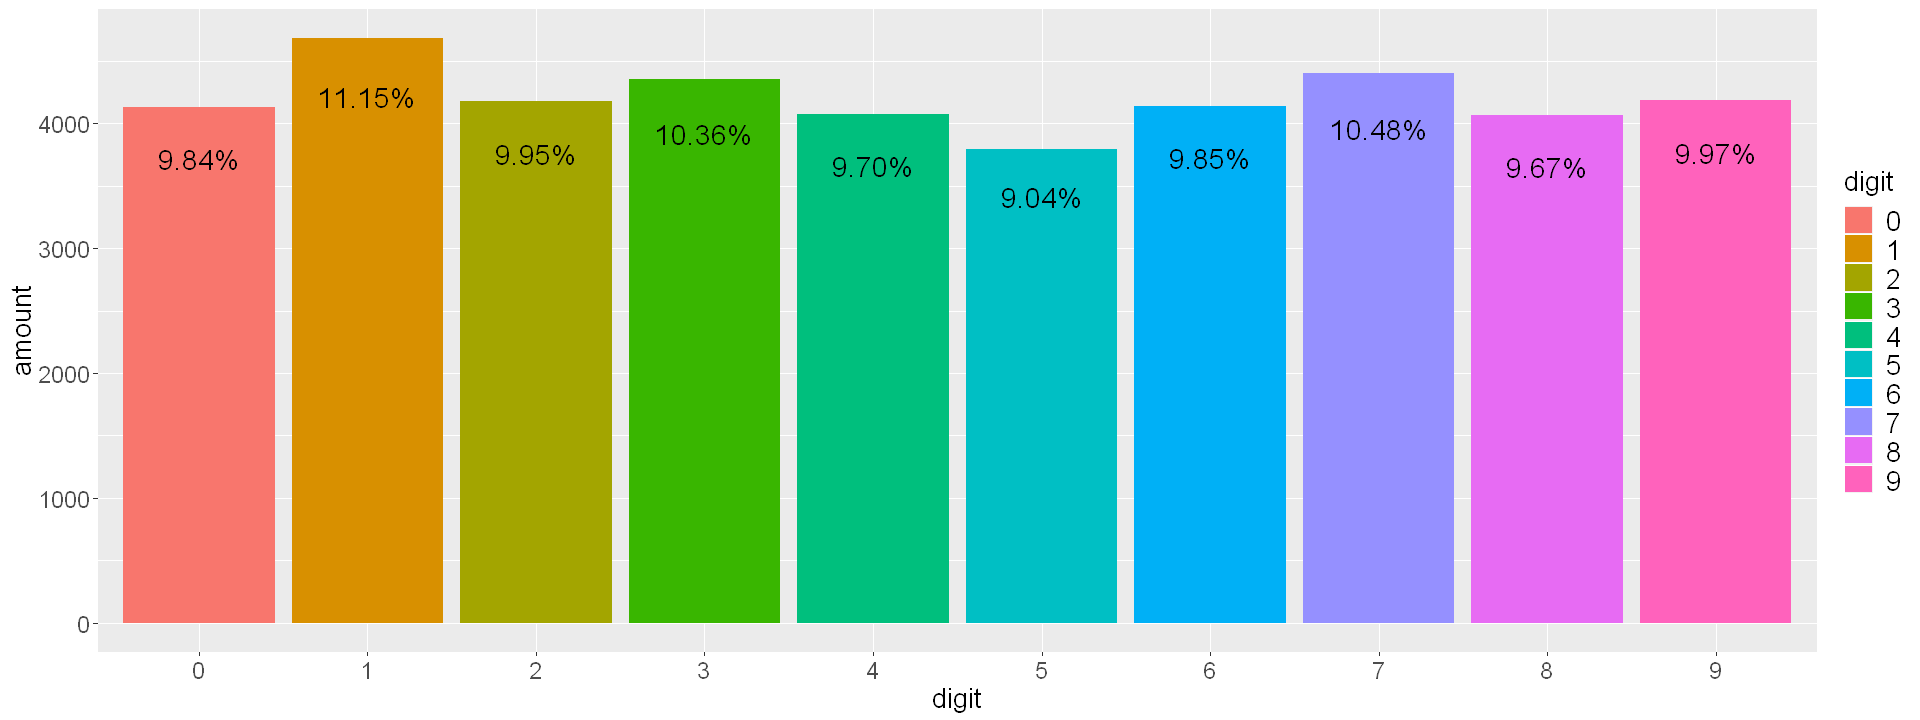

In [12]:
barplot
rm(tbl)
options(repr_option_defaults)

### Nan-Values
Check for nan-values. Nothing at all.

In [13]:
sum(is.na(train))
sum(is.na(test))

[1] 0

[1] 0

### Pixel Distribution in the Center of Image

Let's check the feature distribution in the center of image. For these purposes I took 4 pixels in the center and plot histograms of their intensity for each digit. The brightness of the pixels is varying from digit to digit, and it's pretty logcally: For instance, when you write `8` in majority of cases its junction point is in the center, or really close to. However for the `7` the situation is opposite, it almost never crosses through the central pixels.

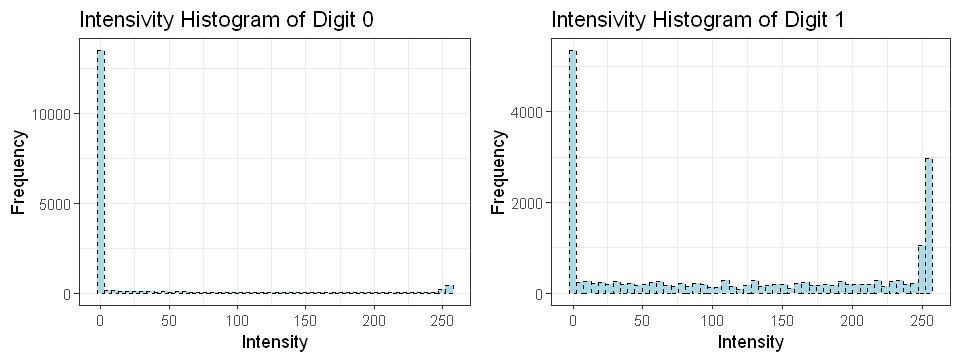

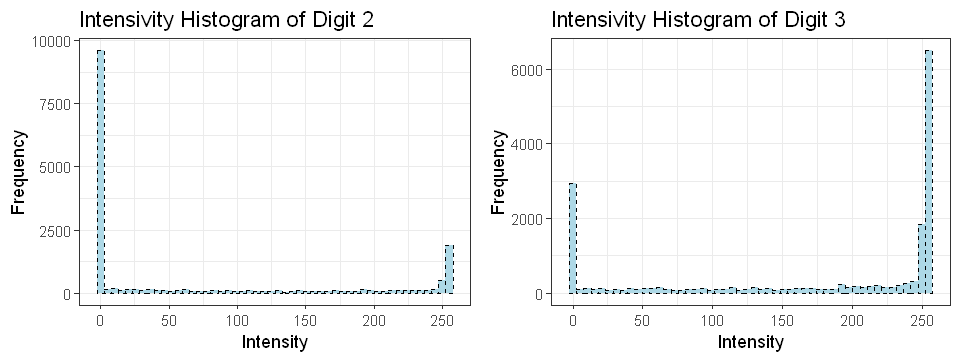

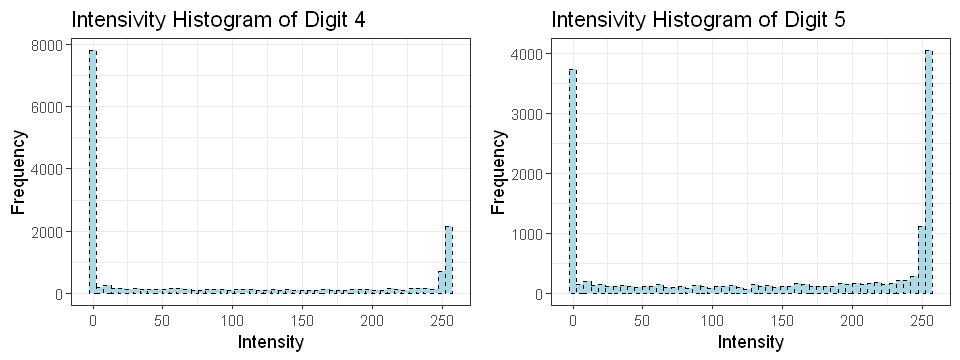

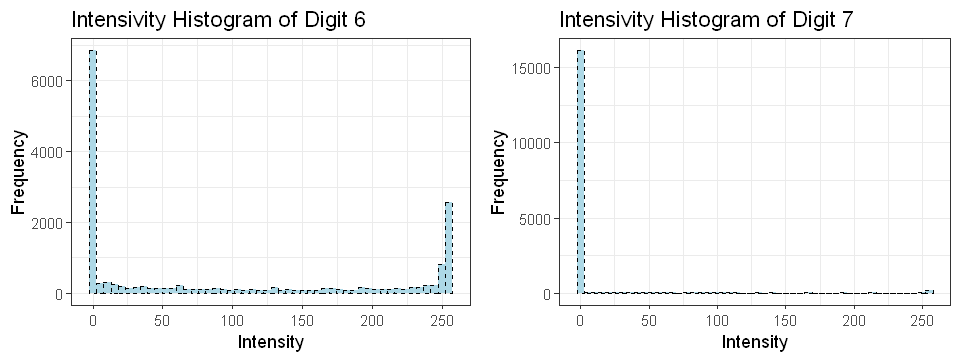

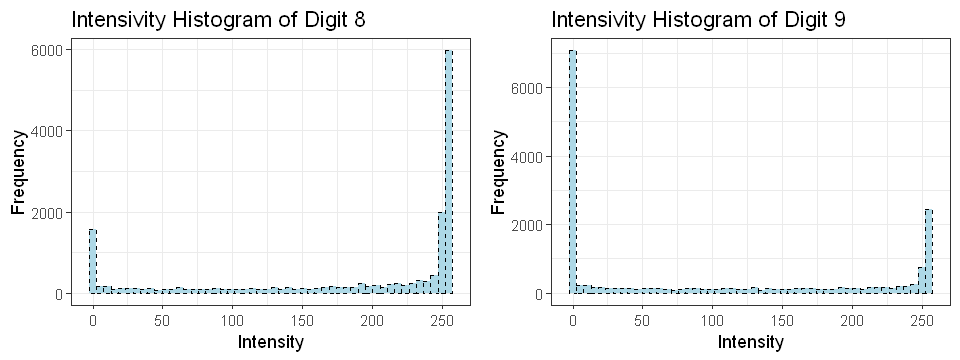

In [14]:
central_block <- c("pixel376", "pixel377", "pixel404", "pixel405")
par(mfrow=c(2, 2))
options(repr.plot.width=8, repr.plot.height=3)
for (i in seq(0, 8, by=2)){
    tbl <- reshape(train[train$label == i, central_block], direction="long", varying=central_block, timevar=NULL, v.names = "pixels.intensity")
    p <- ggplot(tbl, aes(x=pixels.intensity)) + 
         geom_histogram(color="black", fill="lightblue", linetype="dashed", bins=50) + 
         theme_bw() + 
         labs(title = sprintf("Intensivity Histogram of Digit %d", i), x = "Intensity", y = "Frequency") +
         scale_x_continuous(breaks = seq(0, 250, by = 50))
    
    tbl <- reshape(train[train$label == i + 1, central_block], direction="long", varying=central_block, timevar=NULL, v.names = "pixels.intensity")
    p2 <- ggplot(tbl, aes(x=pixels.intensity)) + 
          geom_histogram(color="black", fill="lightblue", linetype="dashed", bins=50) + 
          theme_bw() + 
          labs(title = sprintf("Intensivity Histogram of Digit %d", i + 1), x = "Intensity", y = "Frequency") +
          scale_x_continuous(breaks = seq(0, 250, by = 50))
    grid.arrange(p, p2, ncol=2)
}
rm(tbl)
options(repr_option_defaults)

## Models building

### Data point

For the further explanations,I'd like to define some abstract data points:
- ***X*** - vector of explanatory variables (features)
- ***Y*** - categorical outcome, which corresponds with ***X*** ($X_{1i} ... X_{Mi} \rightarrow Y_i$, where $Y_i \in [0 ... K]$)
- ***N*** - series of observed data (amount of observed data)
- ***M*** - explanatory variables ($X_{1i} ... X_{Mi}$ number of features)
- ***K*** - the number of classes - 1. In this case ***K***=9

### Data Split
To begin with a model we split the training data according to the [80/20 ratio rule](https://en.wikipedia.org/wiki/Pareto_principle). Though, we already have the test data, provided by the Kaggle, for the validation purposes we split the training data.

In [7]:
set.seed(42)

In [8]:
# acquire the separating index between the training and validation split
train_split_index <- createDataPartition(train$label, p=0.8, list=FALSE)

In [9]:
# Create splited datasets
train_split <- train[train_split_index,]
test_split <- train[-train_split_index,]

### Multinomial Logistic Regression
Let's begin with the logit model dedicated for multiclass prediction. Technically, the multinomial logistic regression is the logistic regression generalized for multiclass prediction. Detailed information could be found on [Wikipedia](https://en.wikipedia.org/wiki/Multinomial_logistic_regression). However I will shorthand and adjust this info:

**The basis:**

The multinomial logit is the linear predictor function, which counts a score from weights linear combined with features:

$$
score(X_i,\ k) = \beta_k \cdot X_i
$$

* $X_i$ - vector of features of i-th observation
* $k$ - possible outcome class
* $\beta_k$ - regression coefficients, associated with $k$ outcome

The score can directly be converted to a probability value, indicating the probability of observation *i* choosing outcome *k* given the measured characteristics of the observation. This gives us a way to incorporate each model into larger model, where the predictions of such submodels become the inputs for the higher-level model. And their errors tend multiply. For example, imagine a large predictive model that is broken down into a series of submodels where the prediction of a given submodel is used as the input of another submodel, and that prediction is in turn used as the input into a third submodel, etc. If each submodel has 90% accuracy in its predictions, and there are five submodels in series, then the overall model has only 0.95 = 59% accuracy. 

**Linear predictor**

Due to we use multinomial logistic regression, we have to build linear predictor function $f(i, k)$, which returns a probability that $i^{th}$ observation belongs to the $k$ class.

$$
f(i,\ k) = \beta_{0,k}X_{0,i} + \beta_{1,k}X_{1,i} + \beta_{2,k}X_{2,i} + \dots + \beta_{M,k}X_{M,i}
$$

Or in more generalized form (dot product of weight-vector ($\beta_k$) and feature-vector ($x_i$)):

$$
f(i,\ k) = \begin{bmatrix} \beta_{0,k} & \beta_{1,k} & \ldots & \beta_{M,k} \end{bmatrix} \cdot \begin{bmatrix} X_{0,i} \\ X_{1,i} \\ \vdots \\ X_{M,i} \end{bmatrix} = \beta_k \cdot x_i
$$

There are few ways to build the multinomial logit model:
- **[set of independent binary regressions](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#As_a_set_of_independent_binary_regressions)**
- **[log-linear model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#As_a_log-linear_model)**
- **[atent-variable model](https://en.wikipedia.org/wiki/Multinomial_logistic_regression#As_a_latent-variable_model)**

Let's consider only the **log-linear** model:

The log-linear model a little differs from the normal logistic regression. In the ordinary one we build so-called log-odds ($\log({\frac{p_i}{1-p_i}})$), where $p_i$ is the probability of occurance for $i^{th}$ data point on the standard logistic function $\sigma:\mathbb{R} \rightarrow (0,1)$ is defined as 

$$
\sigma = \frac{1}{1 - e^{-t}}
$$
where $t$ - exactly is the linear predictor function. However in the log-linear model, instead of writing the logit of the probabilities $p_i$ as a linear predictor, we separate the linear predictor into $K$, one for each of the $K$ outcomes:

$$
\ln{\text{Pr}(Y_i = 0)} = \beta_0 \cdot X_i - \ln{Z} \\
$$
$$
\ln{\text{Pr}(Y_i = 1)} = \beta_1 \cdot X_i - \ln{Z} \\
$$
$$
\ldots
$$
$$
\ln{\text{Pr}(Y_i = K)} = \beta_K \cdot X_i - \ln{Z}
$$

We use [normalization factor](https://en.wikipedia.org/wiki/Normalizing_constant) $-\ln{Z}$ to ensure that the whole set of probabilities forms a probability distribution, i.e. so that they all sum to one:

$$
\sum _{k=0}^{K}\Pr(Y_{i}=k)=1
$$

Exponentiating both sides turns the additive term into a multiplicative factor 
$$
{\begin{aligned}
\ln{\text{Pr}(Y_i = c)} = \beta_c \cdot X_i - \ln{Z}\\ &\implies \ln{\text{Pr}(Y_i = c)} + \ln{Z} = \beta_c \cdot X_i\\ &\implies \ln{\text{Pr}(Y_i = c) \cdot Z} = \beta_c \cdot X_i\\ &\implies \text{Pr}(Y_i = c) \cdot Z = e^{\beta_c \cdot X_i}\\ &\implies \text{Pr}(Y_i = c) = \frac{1}{Z} \cdot e^{\beta_c \cdot X_i}
\end{aligned}}
$$
so that the probability is just the [Gibbs measure](https://en.wikipedia.org/wiki/Gibbs_measure):

$$
{\begin{aligned}\Pr(Y_{i}=0)&={\frac {1}{Z}}e^{{\boldsymbol {\beta }}_{0}\cdot \mathbf {X}_{i}}\,\\\Pr(Y_{i}=1)&={\frac{1}{Z}}e^{{\boldsymbol {\beta }}_{1}\cdot \mathbf {X} _{i}}\,\\\cdots &\cdots \\\Pr(Y_{i}=K)&={\frac {1}{Z}}e^{{\boldsymbol {\beta }}_{K}\cdot \mathbf {X} _{i}}\,\\\end{aligned}}
$$

We know all probabilities sum to one, so that we can compute $Z$:

$$
1 = \sum_{k=0}^K{\Pr(Y_i = k)} = \sum_{k=0}^K{\frac{1}{Z}e^{\beta_k \cdot X_i}} = \frac{1}{Z}\sum_{k=0}^K{e^{\beta_k \cdot X_i}}
$$

Thus:

$$
Z = \sum_{k=1}^K{e^{\beta_k \cdot X_i}}
$$

The generalized equation for the probability is:

$$
\Pr(Y_i = c) = \frac{e^{\beta_c \cdot X_i}}{\sum_{k=0}^K{e^{\beta_k \cdot X_i}}}
$$

Let's turn the function $\sigma: \mathbb{R}^K \rightarrow \mathbb{R}^K$, which applies the exponentional function to each $X_i$ observation and then normalize it by deviding over all these exponentials. The normalization ensures us the output vector sum to 1 (As the probabilities do).

$$
\sigma(x)_c = \frac{e^{x_c}}{\sum_{k=0}^K{e^{x_k}}}
$$

The function calls [softmax function](https://en.wikipedia.org/wiki/Softmax_function). I already applied this function to our task, and it almost fully fits to the problem:

$$
\operatorname{softmax}(c, x_1, \ldots, x_n) = \frac{e^{x_c}}{\sum_{k=0}^K{e^{x_k}}}
$$

The softmax function we use in purpose to exaggerate and exhibit the difference among the data $(x_1, \ldots, x_n)$. Softmax returns a value close to 0 in the case where $x_c$ is significantly less than the maximum of all the values, whereas if $x_c$ is either the highest value from $(x_1, \ldots, x_n)$ or extremely approximated to it Softmax returns a value close to 1. Thus, the softmax function can be used to construct a weighted average that behaves as a smooth function and which approximates the indicator function

$$
f(k)={
\begin{cases}
1\;{\textrm {if}}\;k=\operatorname {\arg \max } (x_{1},\ldots ,x_{n}),\\
0\;{\textrm {otherwise}}.
\end{cases}}
$$

Thus, we can write the probability equations as

$$
\Pr(Y_i = c) = \operatorname{softmax}(c, \beta_0 X_i, \ldots, \beta_K X_i)
$$

In this case the softmax serves as ordinar binary logistic regression. Actually, that's it, our predictor is the softmax, which is similar to binary logistic regression, but dedicated for the multiclass prediction.

**Weight obtainig**

The optimal model $\beta$ is obtained by minimizing the cost (also called log loss), which is defined as:

$$
J(\beta) = - \big[\sum_{i=1}^N \sum_{c=0}^c{1_{\{Y_i = c\}}\log{\frac{e^{\beta_cX_i}}{\sum_{j=0}^K{e^{\beta_jX_i}}}}}\big]
$$

where $1_{\{Y_i = c\}}$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function), defined as:

$$
1_{\{Y_i = c\}}={
    \begin{cases}
    1,\;{\textrm {if}}\;Y_i = c\\
    0,\;{\textrm {otherwise}}.
    \end{cases}}
$$

As usual we resort to gradient descent, an iterative optimization algorithm, to solve for the optimal $\beta$. In each iteration, $\beta$ moves a step that is proportional to the negative derivative $\Delta \beta$ of the objective function at the current point. That is, $\beta:=\beta – \eta \Delta \beta$, where $\eta$ is the learning rate. Each column $\Delta\beta_c$  of $\Delta \beta$ can be computed as:

$$
\Delta \beta_c = \frac{\partial J(\beta)}{\partial \beta_j} = - \sum_{i=1}^N[X_i (1_{\{Y_i = c\}} - \Pr(Y_i = c | X_i, \beta))]
$$

The well trained model, the optimal $\beta$ will be used to classify a new sample $\beta'$ by:

$$
Y_i' = \arg \max \frac{e^{\beta_cX_i'}}{\sum_{j=0}^K{e^{\beta_jX_i'}}} = \arg \max(\beta_c, X_i')
$$

In [18]:
mult_lr <- multinom(label ~ ., data=train_split, MaxNWts=10000, decay=5e-3, maxit=100)

# weights:  7860 (7065 variable)
initial  value 77376.069465 
iter  10 value 19048.304810
iter  20 value 12515.465847
iter  30 value 10721.756592
iter  40 value 9937.085896
iter  50 value 9455.963105
iter  60 value 9140.251283
iter  70 value 8941.042519
iter  80 value 8825.040411
iter  90 value 8755.500412
iter 100 value 8705.373578
final  value 8705.373578 
stopped after 100 iterations


> - `MaxNWts=10000` - the maximum number of weigths. (we have $28 \times 28 = 784$ dimensions, in addition to which $1$ is the bias, specified for every single class (i.e. $10$ classes)), therefore we get $(784 + 1) \times 10 = 7850$.
> - `decay=5e-3` - The regularization strength, the weight decay is 0.005
> - `maxit=100` - The maximum number of iterations (epochs) is set to be 100

In [20]:
prediction_lr <- predict(mult_lr, test_split, type = "class")

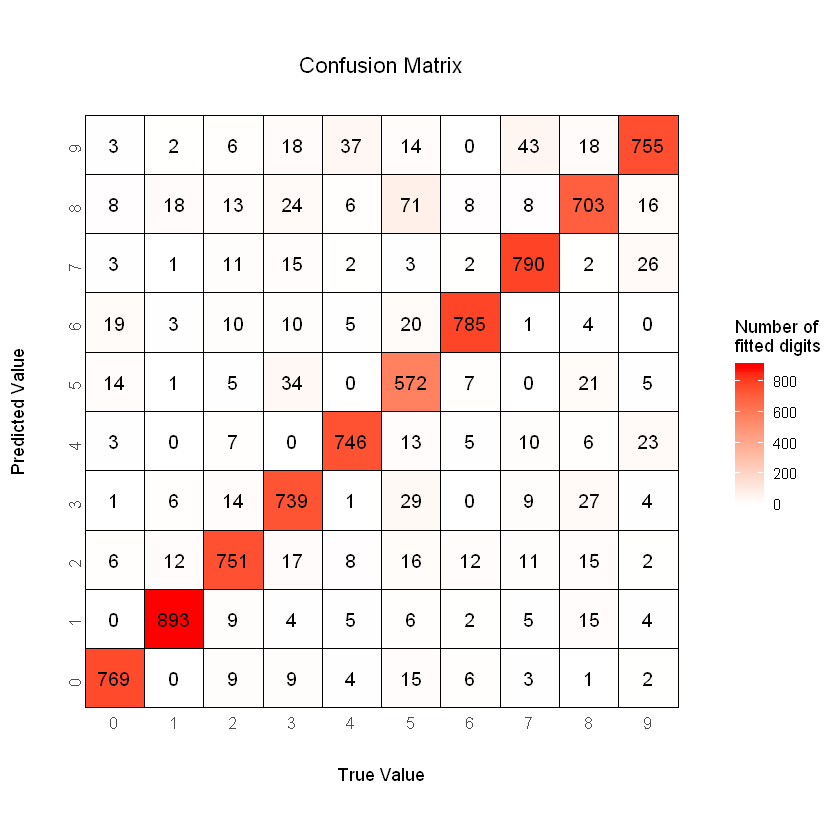

In [135]:
confusion_matrix(prediction_lr, test_split$label)

In summary of the plot above we get 89% model's accuracy.

In [20]:
accuracy_lr = mean(prediction_lr == test_split$label)
accuracy_lr

[1] 0.8936398

### One-Layer Neural Network

Technically, the previous (multiple logistic regression) method is the feed-forward neural network without hidden layers, thus the input layer is directly connected to the output layer. Theoretically, the accuracy (relationship equation) would be enhanced through the adding additional layers to neural network. But it will increase the training time. So to begin with, I'd like to add only one hidden layer. It should looks like:

$$
\begin{bmatrix} \text{Input}-1 \\ \text{Input}-2 \\ \vdots \\ \text{Input}-784 \end{bmatrix} \xrightarrow{w^{(1)}}
\begin{bmatrix} \text{Hidden neuron}-1 \\ \text{Hidden neuron}-2 \\ \vdots \\ \text{Hidden neuron}-H\end{bmatrix} \xrightarrow{w^{(2)}} \begin{bmatrix} \text{Output}-0 \\ \text{Output}-1 \\ \vdots \\ \text{Output}-9\end{bmatrix}
$$

You can look for the data definition [over here](#Data-point). However, we should turn few others:

- $w^{(1)}$ - the weigth matrix connects input and hidden layer. So that, $w^{(1)} \in \mathbb{R}^{N \times H}$, where $w_{h}^{(1)}$ represents the coefficients associated with the $h^{th}$ hidden unit. So, the output (also called activation) of the $h^{th}$ hidden unit $a^{(2)}_h$ can be expressed mathematically as:

 $$
 a^{(2)}_h = f(z^{(2)}) = f(w^{(1)}_h X)
 $$
 
The $f()$ is the activation function. Often it appears as $sigmoid$ (the function used in the logit) or $than$ functions.
* $$
     sigmoid(x) = \frac{1}{1 + e^{-x}}
 $$

* $$
    than(x) = \frac{e^{-x} - e^{-x}}{e^x + e^{-x}} = \frac{2}{1 + e^{-2x}} - 1
$$
| **sigmoid (logit)** | **than**| 
|:--:| :--:|
| ![sigmoid](./imgs/sigmoid.png) | ![than](./imgs/than.png) |


- $w^{(2)}$ - the weight matrix connects hidden and output layer. $w^{(2)} \in \mathbb{R}^{H \times K}$. Each column $w^{(2)}_h$ represents the coefficients associated with class $k$. 

The output layer admits as input the output of the hidden layer, i.e. $a^{(2)} = \begin{bmatrix} a^{(2)}_1, & a^{(2)}_2, & \ldots, & a^{(2)}_i\end{bmatrix}$, the probability that the $X_i$ belongs to the $k$ class is:

$$
\Pr(X_i = k) = softmax_k(w^{(2)},a^{(2)})
$$

The training process is similar, it's the gradient descend with the goal of minimizing the mean squared error cost $J(w)$. So that we get the weight matrix vector $W = \begin{bmatrix} w^{(1)}, & w^{(2)}\end{bmatrix}$.

In our case the method of computation $\Delta w$ is the [backpropagation algorithm](https://en.wikipedia.org/wiki/Backpropagation):

> 1. Compute $a^{(2)}$, in our case $sigmoid(w^{(1)}X_i)$, where $w^{(1)}$ is defined randomly. Then, pass $a^{(2)}$ as input to the output layer and compute $a^{(3)}$.
> 2. For the output layer, compute the derivative of the cost function of one sample $j(w)$ with regards to each unit,
$$
\delta^{(3)}_k = \frac{\delta}{\delta z^{(3)}_k}j(w) = -(Y_k - a^{(3)}_k)\cdot f'(z^{(3)}_k)
$$
generally
$$
\delta^{(3)} = -(Y - a^{(3)})\cdot f'(z^{(3)})
$$
> 3. For the hidden layer, we compute the error term $\delta^{(2)}$ based on a weighted average of:
$$
\delta^{(3)} :\delta^{(2)} = ((w^{(2)})^T \delta^{(3)})\cdot f'^{(2)}
$$
> 4. Compute the gradients applying the chain rule:
$$
\Delta w^{(2)} = \frac{\partial J(w)}{\partial z^{(3)}_k}\frac{\partial z^{(3)}_k}{\partial w^{(2)}} = \delta^{(3)}(a^{(2)})^T
$$
$$
\Delta w^{(1)} = \frac{\partial J(w)}{\partial z^{(2)}_k}\frac{\partial z^{(2)}_k}{\partial w^{(1)}} = \delta^{(2)}(X_i)^T
$$

We repeatedly update all weights by taking these steps until the cost function converges.

In [23]:
model_nn <- nnet(label ~ ., data=train_split, size=50, maxit=300, MaxNWts=100000, decay=1e-4)

# weights:  39760
initial  value 125390.452075 
iter  10 value 36732.495132
iter  20 value 19626.146773
iter  30 value 15829.680983
iter  40 value 14869.855355
iter  50 value 14052.225776
iter  60 value 13682.332687
iter  70 value 13098.674178
iter  80 value 12599.680826
iter  90 value 12325.271253
iter 100 value 11970.633433
iter 110 value 11727.462135
iter 120 value 11363.208328
iter 130 value 11161.738585
iter 140 value 11004.788409
iter 150 value 10835.855486
iter 160 value 10733.093814
iter 170 value 10556.927139
iter 180 value 10412.301813
iter 190 value 10256.387805
iter 200 value 10092.271925
iter 210 value 9937.072546
iter 220 value 9830.672818
iter 230 value 9651.551372
iter 240 value 9578.875783
iter 250 value 9504.655293
iter 260 value 9434.619691
iter 270 value 9295.523846
iter 280 value 9194.504468
iter 290 value 9107.783540
iter 300 value 9041.115730
final  value 9041.115730 
stopped after 300 iterations


> - `size=50` - the size of hidden layer. 50 neurons.
> - `MaxNWts=10000` - the maximum number of weigths is 10000. 
> - `decay=1e-4` - The regularization strength, the weight decay is 0.0001
> - `maxit=300` - The maximum number of iterations (epochs) is set to be 300

In [24]:
prediction_nn <- predict(model_nn, test_split, type = "class")

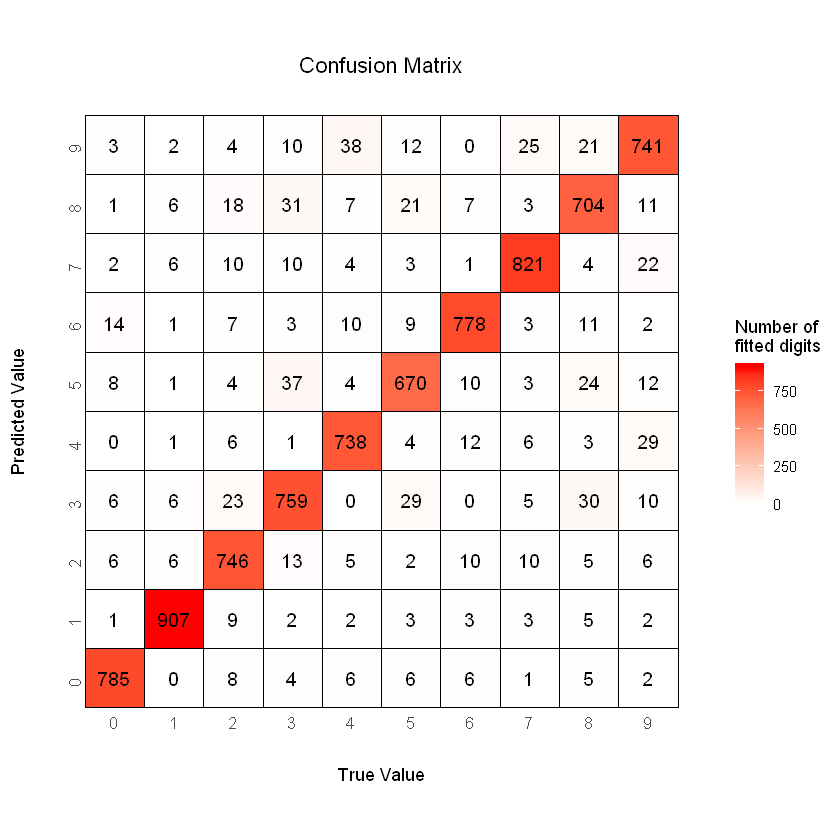

In [25]:
confusion_matrix(prediction_nn, test_split$label)

As a result we obtain 91% of accuracy. Not quite bad, isn't it? *89%* ***->*** *91%*

In [26]:
accuracy_nn = mean(prediction_nn == test_split$label)
accuracy_nn

[1] 0.9110291

### Data Normalization

In purpose to reduce the [illumination effect](https://www.sciencedirect.com/science/article/pii/S0924271617303878) and bolster DNN performance (it's better working with [0;1] rather than [0;255], otherway it's might be be skewed towards some features and such skewness will accumulate over layers.) perform a grayscale normalization.

Shorthand of the grayscale normalization

$$
I:\{\mathbb{X} \subseteq \mathbb{R}^n\} \rightarrow \{\text{Min}, .., \text{Max}\} - \text{the n-dimensional image with intensity values in the range (Min,Max) required to be grayscaled.}
$$

$$
I_N:\{\mathbb{X} \subseteq \mathbb{R}^n\} \rightarrow \{\text{newMin}, .., \text{newMax}\} - \text{new image with new intensity values in the range (newMin,newMax).}
$$

The linear (linear relationship between old pixels and new ones) normalization of a grayscale digital image is performed according to the formula

$$
I_N = (I - \text{Min}) \times \frac{\text{newMax} - \text{newMin}}{\text{Max} - \text{Min}} + \text{newMin}
$$

In our case: $I_N = (\text{each_pixel} - 0) \times \frac{1 - 0}{255 - 0} + 0 = \frac{\text{each_pixel}}{255}$

In [10]:
X_train <- data.matrix(train_split[-label_index])/255.0
X_test <- data.matrix(test_split[-label_index])/255.0

#### One-hot encoding

In [11]:
Y_train <- to_categorical(train_split$label, 10)
Y_test <- to_categorical(test_split$label, 10)

### Two-layers Deep Neural Network
It's inferently, that layer's adding enhances the performance of a neural network. So let's do this:

$$
\begin{bmatrix} \text{Input}-1 \\ \text{Input}-2 \\ \vdots \\ \text{Input}-784 \end{bmatrix} \rightarrow
\begin{bmatrix} \text{Hidden neuron}-1 \\ \text{Hidden neuron}-2 \\ \vdots \\ \text{Hidden neuron}-128\end{bmatrix} \xrightarrow{\text{RELU}}
\begin{bmatrix} \text{Hidden neuron}-1 \\ \text{Hidden neuron}-2 \\ \vdots \\ \text{Hidden neuron}-64\end{bmatrix} \xrightarrow{\text{RELU}} \begin{bmatrix} \text{Output}-0 \\ \text{Output}-1 \\ \vdots \\ \text{Output}-9\end{bmatrix} \xrightarrow{\text{softmax}} \text{Output}
$$

Weights' optimization (RMSProp) we will consider a little bit [further](#Weights'-optimization), it still performs via backpropagation algorithm. The **softmax** activation function is to complicated for the 2+ layers, I mean the computational time will be increasing along with number of layers. Due to this reason we will use [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)):

$$
relu(x) = x^+ = max(0,x)
$$

Using words, it returns 0, whenever $x$ is less than 0, and it returns same value as $x$ otherwise. We have one exquisite property of its derivative:

$$
relu'(x) = \begin{cases}
    1,\;x\geq0 \\
    0,\;x<0
    \end{cases}
$$

The main advantage of using RELU over sigmoid is computational time (when we counts its derivative while training). Comparing to softmax $sigmoid'(x) = sigmoid(x) \cdot (1 - sigmoid(x))$, RELU has only two constants. The second advantage is less likely to have the vanishing gradient problem, exponential decrease of gradient, which can be found in networks with multiple stacked sigmoid layers. As we multiply the derivative of the activation function when calculating errors $\delta$ for each layer, and the maximal value of $sigmoid'(x)$ is $\frac{1}{4}$, the gradients will decrease exponentially as we stack more and more sigmoid layers. At the end (output layer) we use softmax, to get a probability that $X_i$ belongs to $k$ class.

**Dropouts**

To grasp the full idea read the [paper](https://arxiv.org/abs/1207.0580) by its autor.

Dropout is a technique of preventing a DNN from the overfiting. The main idea behind Dropout is to train an ensemble of several DNNs instead of training one DNN and then average the results. Neural networks are obtained by dropping out neurons with a probability $p$, so the probability $1-p$ that a neuron will still in the network is. "Dropping" a neuron means that for any input or parameters, it returns 0.

Let's consider 
- $h(x) = xW+b\ -$ is the linear representation of $d_i-$demensional vector $X$ to the $d_h-$demensional output vector

- $a(h)\ -$ activation function

So, the application of Dropout while training we can consider as activation function modification:

$$
f(h) = D \odot a(h)
$$

where $D=[X_1, \ldots, X_{d_h}]$ is a $d_h-$dimensionall vector of $X_i$ which distributed randomly, according to the Bernoulli distribution:

$$
f(k,p) = \begin{cases}
    p,\; & \text{if }k=1 \\
    1-p,\; & \text{if }k=0
    \end{cases}
$$

Apparently, this random variable perfectly matches the Dropout applied to a neuron. Indeed, the neuron is turned off with probability $p = P(k=1)$, otherwise it remains active.

Apply Dropout to the $i-$th neuron:

$$
O_i = X_i a(\sum_{j=1}^{d_i}{x_jw_j+b}) = \begin{cases}
    a(\sum_{j=1}^{d_i}{x_jw_j+b}),\; & X_i = 1 \\
    0,\; & X_i = 0
    \end{cases}
$$

where $P(X_i = 0) = p$

Since at the training stage the neuron remains in the network with probability $q$, at the testing stage we need to emulate the behavior of the ensemble of neural networks used in training. We will be applying **inverted Droput**, so that as authors suggest we multiply activation function onto $\frac{1}{q} = \frac{1}{1-p}$ while training stage occurs:

* **Training:** $O_i = \frac{1}{q}X_i a(\sum_{j=1}^{d_i}{x_jw_j+b})$
* **Test:** $O_i = \frac{1}{q}X_i a(\sum_{j=1}^{d_i}{x_jw_j+b})$


In [38]:
model_dnn <- keras_model_sequential()

model_dnn %>%
    layer_dense(units = 128, activation = 'relu', input_shape = c(784), kernel_initializer='random_normal',
    bias_initializer='zeros') %>%
    layer_dropout(rate = 0.4) %>% 
    layer_dense(units = 64, activation = 'relu', kernel_initializer='random_normal',
    bias_initializer='zeros') %>%
    layer_dropout(rate = 0.3) %>%
    layer_dense(units = 10, activation = 'softmax', kernel_initializer='random_normal',
    bias_initializer='zeros')

In [39]:
summary(model_dnn)

Model: "sequential_2"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_6 (Dense)                     (None, 128)                     100480      
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 128)                     0           
________________________________________________________________________________
dense_7 (Dense)                     (None, 64)                      8256        
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 64)                      0           
________________________________________________________________________________
dense_8 (Dense)                     (None, 10)                      650         
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_______________

#### Loss function

When we have a multi-class classification task, one of the loss function you can go ahead is **categorical crossentropy**. If you are using CCE loss function, there must be the same number of output nodes as the classes. And the final layer output should be passed through a softmax activation so that each node output a probability value between (0–1). For feeding the target value at the time of training, we have to [one-hot encode them](#One-hot-encoding).

#### Weights' optimization 

Let's begin with another algorithm rather than **RMSProp**. It calls **AdaGrad**.

**AdaGrad**

- As the base we use [Stochastic Gradient Descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) 
$$
g = \frac{1}{m}\nabla_{\theta}\sum_i{L(f(X_i, \theta), Y_i)} \\
\theta = \theta - \varepsilon_k \times g \\
$$ 
SGD updates model parameters ($\theta$) in the negative direction of the gradient ($g$) by taking a subset or a mini-batch of data of size ($m$). The neural network is represented by $f(X_i; \theta)$ where $X_i$ are the training data and $Y_i$ are the training labels, the gradient of the loss $L$ is computed with respect to model parameters $\theta$. The learning rate ($\varepsilon_k$) determines the size of the step that the algorithm takes along the gradient (in the negative direction in the case of minimization and in the positive direction in the case of maximization). The learning rate is a function of iteration $k$ and is a single most important hyper-parameter. A learning rate that is too high (e.g. > $0.1$) can lead to parameter updates that miss the optimum value, a learning rate that is too low (e.g. < $1e^{-5}$) will result in unnecessarily long training time. A good strategy is to start with a learning rate of $1e^{-3}$ and use a learning rate schedule that reduces the learning rate as a function of iterations. In general, we want the learning rate ($\varepsilon_k$) to satisfy the Robbins-Monroe conditions:
$$
\sum_k{\varepsilon_k} = \infty \qquad \sum_k{\varepsilon_k^2} < \infty
$$
The first condition ensures that the algorithm will be able to find a locally optimal solution regardless of the starting point and the second one controls oscillations.
- **AdaGrad** is an adaptive method for setting the learning rate. Consider two scenarios in the Figure below.
![AdaGrad](imgs/AdaGrad.png)
In the case of a slowly varying objective (left), the gradient would typically (at most points) have a small magnitude. As a result, we would need a large learning rate to quickly reach the optimum. In the case of a rapidly varying objective (right), the gradient would typically be very large. Using a large learning rate would result in very large steps, oscillating around but not reaching the optimum.
These two situations occur because the learning rate is set independent of the gradient. AdaGrad solves this by accumulating squared norms of gradients seen so far and dividing the learning rate by the square root of this sum:
$$
g = \frac{1}{m}\nabla_{\theta}\sum_i{L(f(X_i, \theta), Y_i)} \\
s = s + g^Tg \\
\theta = \theta - \varepsilon_k \times \frac{g}{\sqrt{s + \varepsilon}} \\
$$
As a result parameters that receive high gradients will have their effective learning rate reduced and parameters that receive small gradients will have their effective learning rate increased. The net effect is greater progress in the more gently sloped directions of parameter space and more cautious updates in the presence of large gradients.

**RMSProp**

- RMSProp modifies AdaGrad by changing the gradient accumulation into an exponentially weighted moving average, i.e. it discards history from the distant past:
$$
g = \frac{1}{m}\nabla_{\theta}\sum_i{L(f(X_i, \theta), Y_i)} \\
s = \text{decay_rate} \times s + (1 - \text{decay_rate})g^Tg \\
\theta = \theta - \varepsilon_k \times \frac{g}{\sqrt{s + \varepsilon}} \\
$$
Notice that AdaGrad implies a decreasing learning rate even if the gradients remain constant due to accumulation of gradients from the beginning of training. By introducing exponentially weighted moving average we are weighing recent past more heavily in comparison to distant past. As a result, RMSProp has been shown to be an effective and practical optimization algorithm for deep neural networks.

#### Metrics

Let's take a look a confusion matrix

![confusion_matrix](imgs/confusion_matrix.png)

The **accuracy** metrics takes a ratio of the number of fitted (properly pedicted) entities (***True-Positive (TP)*** and ***True-Negative (TN)***) over the overall number of observations (**TP + TN + FP + FN**).

$$
\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. As we may noticed [here](#First-look) the classes are balanced and each one approaches to 10% of dataset.

In [40]:
model_dnn %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [41]:
set.seed(42)
history <- model_dnn %>% fit(
  X_train, Y_train, 
  epochs = 30, batch_size = 100, 
  validation_data=list(X_test, Y_test)
)

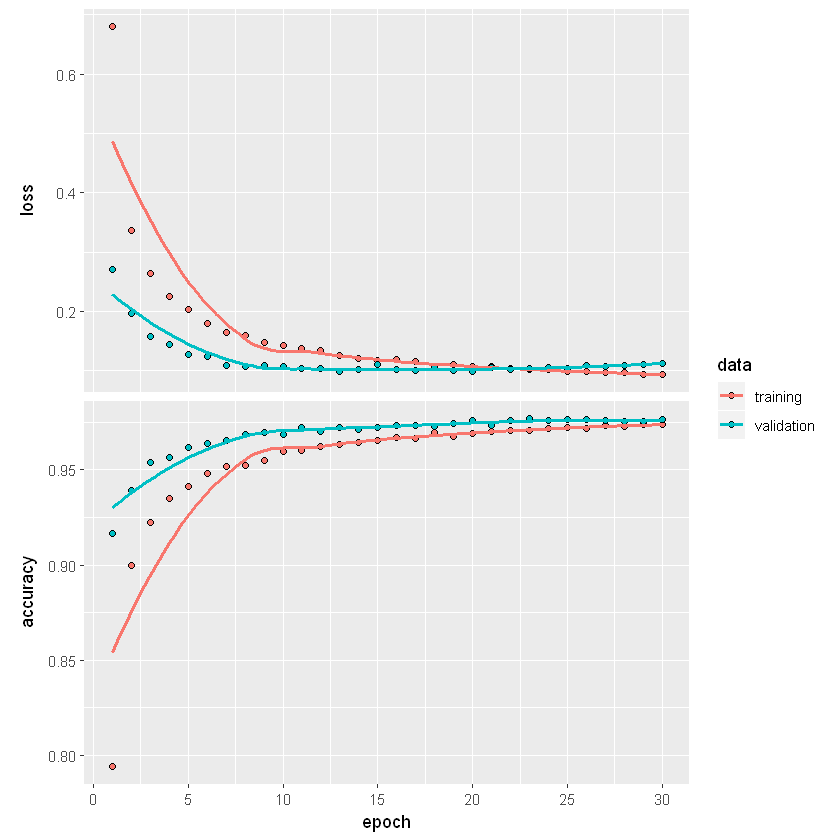

In [42]:
plot(history)

97% accuracy. It looks great. *89%* **->** *91%* **->** *97%*

In [46]:
evaluate(model_dnn, X_test, Y_test)

loss  accuracy 
0.1131200 0.9765365

In [47]:
prediction_dnn <- predict_classes(model_dnn, X_test)

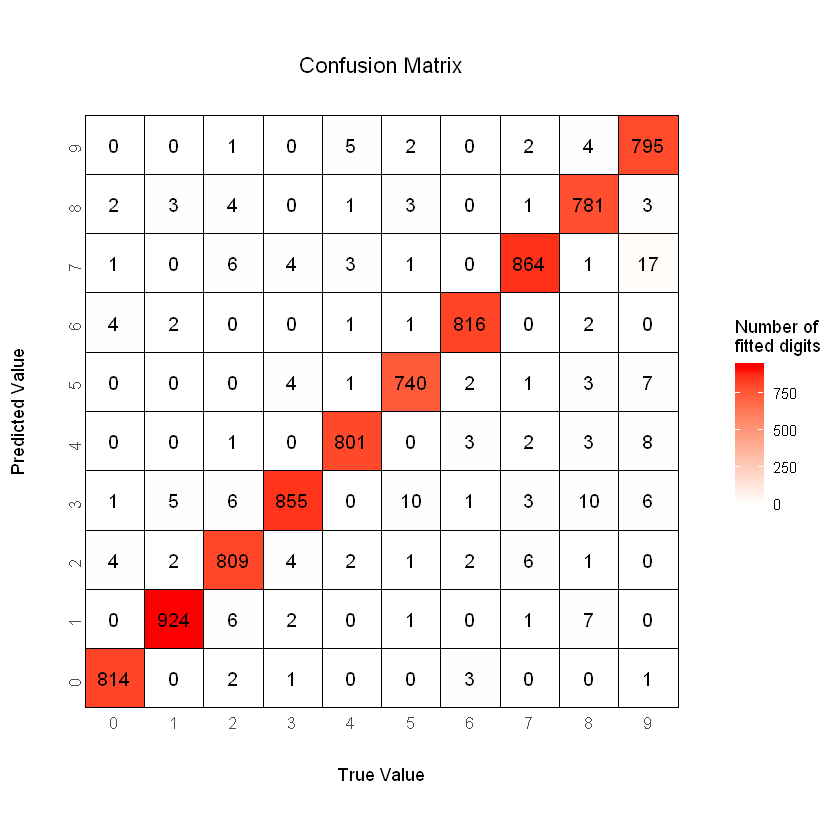

In [48]:
confusion_matrix(prediction_dnn, test_split$label)

### [Convolutional Neural Network](https://cs231n.github.io/convolutional-networks/)

The CNN is pretty common way to detect specific features on an image. I'ill take a brief note how does it work, the [full description](https://cs231n.github.io/convolutional-networks/) you could find by Google it. CNNs is the variant of multi-layered neural networks which are biologically inspired by the human visual cortex. Basically, CNNs take inspiration from the following two neuroscience findings:

> 1. The visual cortex has a complex system of neuronal cells that are sensitive to specific sub-regions of the visual field, called the receptive field. For instance, some cells respond only in the presence of vertical edges; some cells fire only when exposed to horizontal edges; and some react more strongly when shown edges of a certain orientation. The cells are organized together to produce the entire visual perception, while each individual cell is specialized in a specific component.
> 2. Simple cells respond only when those edge-like patterns are presented within their receptive sub-regions. More complex cells are sensitive to larger sub-regions, and as a result, are less variant to the local position of those edge-like patterns in the entire visual field.

CNNs classify images by first deriving low-level representations, local edges and curves, then by composing higher-level representations, overall shape and contour, through a series of low-level representations. CNNs are well suited to exploiting strong and unique features that differentiate between images.

**Classic CNN structure**
1. Convolutional Layer
2. Activation operation following each convolutional layer
3. Pooling layer especially Max Pooling layer and also others based on the requirement
4. Finally Fully Connected Layer

**Convolutional operation**

First of all, we resize an input image to preferable size, in our case $28 \times 28 \times 1$ (height x width x color depth(3 - RGB, 1 - black intensity)). There is a specific kernel which one is less in size than original image. Let's consider a kernel with size $5 \times 5 \times 1$, the kernel slides over the original image and does element-wise multiplication of the kernel and the image's field on which kernel is aimed, further we sum up all elements of an obtained matrix. And the sum we got becomes an element of so-callled **feature map**. Let's a little bit simplify and imagine the image as a matrix $I \in \mathbb{R}^{28 \times 28}$, where $I_{i,j} \in [0; 1]$ represents pixel's intensity (0 - white, 1 - black). In addition consider kernel $K \in \mathbb{R}^{5 \times 5}$ (a matrix with simple edge):

$$
I = \begin{bmatrix}
    \text{pixel}_{0,0} & \ldots & \text{pixel}_{0,28} \\
    \vdots & \ddots & \vdots \\
    \text{pixel}_{28,0} & \ldots & \text{pixel}_{28,28} \\
\end{bmatrix} \quad
K = \begin{bmatrix}
    0 & 0 & 0 & 1 & 1 \\
    0 & 0 & 1 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
\end{bmatrix} \\
\text{Feature map element} = e^T(I \odot K)e = \sum{(I \odot K)} = \sum_{i = 1}^5{\sum_{j=1}^5{I_{i,j} \times K_{i,j}}}
$$

where, $e$ - colummn vector consists of only 1

![kernel](imgs/conv.png)

In the example above the process looks like:

$$
e^T(I \odot K)e = \sum{\left(
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0.0627451 \\
    0 & 0 & 0 & 0.49411765 & 0.90980392 \\
    0 & 0 & 0.51764706 & 0.99215686 & 0.98823529 \\
    0.01568627 & 0.37647059 & 0.99215686 & 0.96862745 & 0.69019608\\
    0.22352941 &  0.98823529 & 0.9882352 & 0.69019608 &  0 \\
\end{bmatrix} \odot
\begin{bmatrix}
    0 & 0 & 0 & 1 & 1 \\
    0 & 0 & 1 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 \\
\end{bmatrix}
\right)
} = \sum{\left(
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0.0627451 \\
    0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 \\
    0 & 0.37647059 & 0 & 0 & 0\\
    0 & 0.98823529 & 0 & 0 &  0 \\
\end{bmatrix}\right)
} \approx 1.42745098
$$

Apparently, in case $e^T(I \odot K)e$ is large then the field under the kernel is closely similar to the kernel's filter itself, otherwise if $e^T(I \odot K)e$ approaches to 0 then the coincidence between kernel and field under kernel also approaches to 0.

We just deemed only one kernel, however we apply a bunch of them (20 in the following case), thus get a bunch of feature maps.

<img src='imgs/conv_1.png' align=left width=240>
          
<img src='imgs/conv_2.png' align=left width=240> 

<img src='imgs/conv_3.png' align=left width=240> 

<img src='imgs/conv_4.png' width=240>  

And so on... Similar to any other NN, we use an activation function to make our output non-linear. In the case of a Convolutional Neural Network, the output of the convolution will be passed through the activation function. This could be the ReLU activation function.

**Strides and Paddings**

- **Stride** - is the size of the step the convolution filter moves each time. A stride size is usually 1, meaning the filter slides pixel by pixel. By increasing the stride size, your filter is sliding over the input with a larger interval and thus has less overlap between the cells.

- **padding** - Because the size of the feature map is always smaller than the input, we have to do something to prevent our feature map from shrinking. This is where we use padding. A layer of zero-value pixels is added to surround the input with zeros, so that our feature map will not shrink. In addition to keeping the spatial size constant after performing convolution, padding also improves performance and makes sure the kernel and stride size will fit in the input.

I won't stuck here up, you can look for some additional information in the internet. However I'd like to note that in the example above I represented **stride** = 1, contrary to the code `strides = c(2,2)`. The reason that I do these pictures by myself, and it knocks me up:))

**Pooling operation**

In purpose to avoid overfiting and reduce computational time we use **Pooling layer** berween conv. layers. The main idea is to reduce the dimension of feature map without losing the features itself. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

- Accepts a volume of size: $W_i \times H_i \times D_i$ (in our case $D_i = 1$ (black only))
- Requires two hyperparameters:
 - their spatial extent $F$
 - the stride $S$
- Produces a volume of size $W_o \times H_o \times D_o$ where:
 - $W_o = (W_i - F)/(S + 1)$
 - $H_o = (H_i - F)(S + 1)$
 - $D_o = D_i$
- Introduces zero parameters since it computes a fixed function of the input
- For Pooling layers, it is not common to pad the input using zero-padding.

It is worth noting that there are only two commonly seen variations of the max pooling layer found in practice: A pooling layer with $F=3,S=2$ (also called overlapping pooling), and more commonly $F=2,S=2$. Pooling sizes with larger receptive fields are too destructive.

**General pooling**. In addition to max pooling, the pooling units can also perform other functions, such as average pooling or even L2-norm pooling. Average pooling was often used historically but has recently fallen out of favor compared to the max pooling operation, which has been shown to work better in practice.

<img src='imgs/pool.jpeg' align='left' width=240>
<img src='imgs/maxpool.jpeg' width=480>

**Fully-Connected Layer**

At the end, we have to interpret the output of preceding conv. and pooling layers as probabilities of belonging an observation to a class. We use fully-connected layers as we did in the previous NNs. However, FC-layers accepts only 1-D input (in opposite to the current 3-D), thus we convert our 3-D array to the 1-D, using `flatten` function. Also to avoid overfitting, we turn a half of neurons off, in addition to the l2-regularization.

**L2 - regularization (Ridge regression)**

To learn a neural network we intend to minmize the loss function, by fitting it to the training datapoint, and using Gradient Descend in purpose to find its minimal:

$$
\text{minimize}(Loss(\text{Data|Model}))
$$

To avoid the overfitting (when the learning curve fits to the training  data too well, and it does mistakes for the validation data, because they may be different) we'll now minimize loss+complexity, which is called **structural risk minimization**: 
$$
\text{minimize}(Loss(\text{Data|Model}) + Complexity(\text{Model}))
$$

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function.

$$
\sum_{i=1}^{N}{(Y_i - \sum_{j=1}^{M}{(X_{i,j}W_j)})^2} + \lambda \sum_{j=1}^{M}{W_j^2}
$$

Performing L2 regularization has the following effect on a model

* Encourages weight values toward 0 (but not exactly 0)
* Encourages the mean of the weights toward 0, with a normal (bell-shaped or Gaussian) distribution.

Increasing the lambda value strengthens the regularization effect. For example, the histogram of weights for a high value of lambda might look as shown in left-side figure. Lowering the value of lambda tends to yield a flatter histogram, as shown in rigth-side figure.

<img src='imgs/HighLambda.svg' align=left width=480>

<img src='imgs/LowLambda.svg'  width=440>

When choosing a lambda value, the goal is to strike the right balance between simplicity and training-data fit:

* If your lambda value is too high, your model will be simple, but you run the risk of underfitting your data. Your model won't learn enough about the training data to make useful predictions.

* If your lambda value is too low, your model will be more complex, and you run the risk of overfitting your data. Your model will learn too much about the particularities of the training data, and won't be able to generalize to new data.

Finally, the output layer gives us a probability of belonging an observation to $k^{th}$ class. We get this probability via **softmax**.

Reshape the data to the apropriate dimension. In our case $\text{Input} = \mathbb{R}^{28 \times 28}$

In [12]:
X_train_cnn <- array_reshape(X_train, c(-1, 28, 28, 1))
X_test_cnn <- array_reshape(X_test, c(-1, 28, 28, 1))

In [13]:
model_cnn <- keras_model_sequential() %>% 
    layer_conv_2d(filters = 20, kernel_size = c(5, 5), activation = "relu", input_shape = c(28, 28, 1)) %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides=c(2,2)) %>%
    layer_conv_2d(filters = 50, kernel_size = c(5, 5), activation = "relu") %>%
    layer_max_pooling_2d(pool_size = c(2, 2), strides=c(2,2)) %>%
    layer_flatten() %>%
    layer_dropout(rate=0.5) %>%
    layer_dense(units = 500, activation = "relu", kernel_regularizer = regularizer_l2(l = 0.0001)) %>%
    layer_dense(units = 10, activation = "softmax", kernel_regularizer = regularizer_l2(l = 0.0001))

For the learning uses the same parameters as in the DNN before.

In [14]:
model_cnn %>% compile(
  loss = 'categorical_crossentropy',
  optimizer = optimizer_rmsprop(),
  metrics = c('accuracy')
)

In [15]:
set.seed(42)
history <- model_cnn %>% fit(
  X_train_cnn, Y_train, 
  epochs = 30, batch_size = 100, 
  validation_data=list(X_test_cnn, Y_test),
  verbose = 2
)

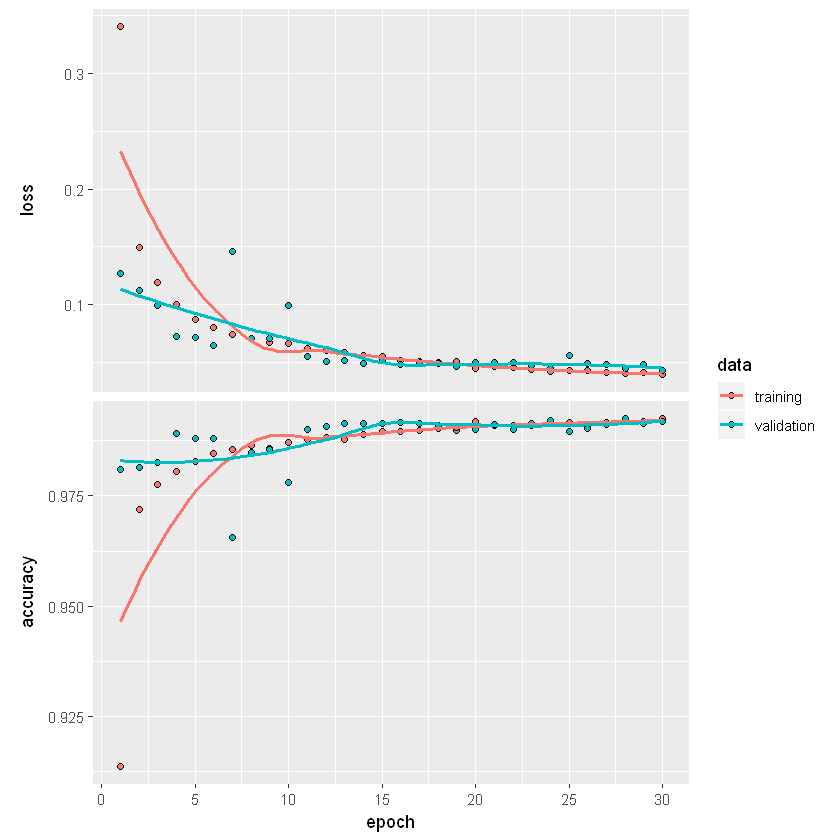

In [16]:
plot(history)

Wow! 99% is perfect. Thus, *89%* **->** *91%* **->** *97%* **->** *99%*

Therefore, we may assume that CNN is the best aaproach to this problem. We may enhance it by tuning its hyperparameters ([check this out](https://towardsdatascience.com/a-walkthrough-of-convolutional-neural-network-7f474f91d7bd)), but I suppose it's good enough.

In [17]:
evaluate(model_cnn, X_test_cnn, Y_test)

loss   accuracy 
0.04263082 0.99178177

In [18]:
prediction_cnn <- predict_classes(model_cnn, X_test_cnn)

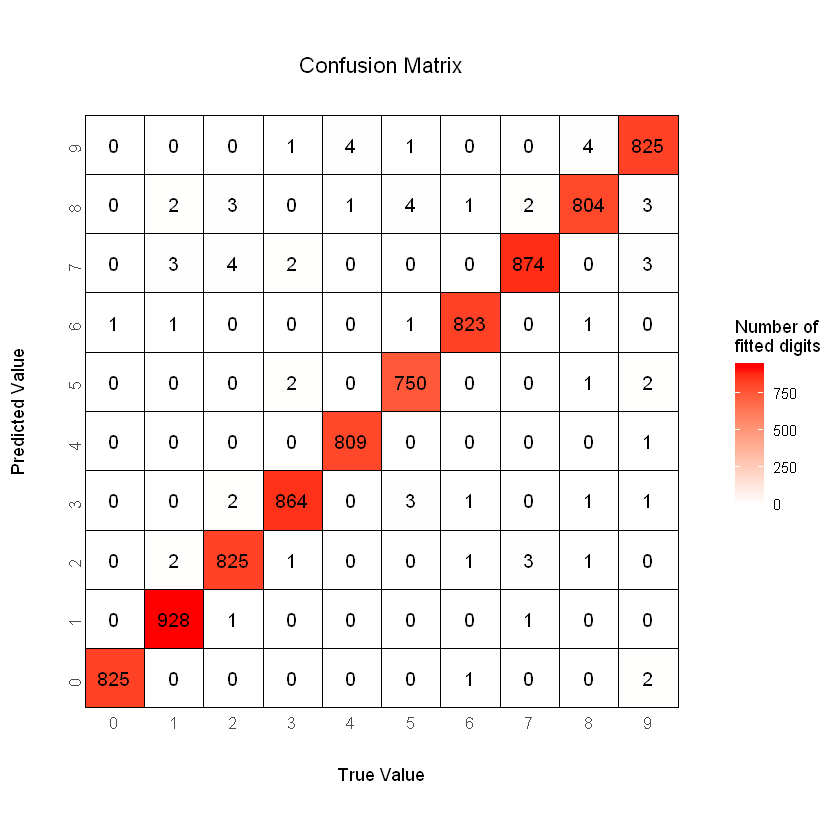

In [19]:
confusion_matrix(prediction_cnn, test_split$label)

In [ ]:
tuning_run(file="cnn_model.R", flags = list( dropout = c(0.2, 0.3, 0.4, 0.5), lambda = c(0.001, 0.0001, 0.00003) ))

12 total combinations of flags (use sample parameter to run a random subset)


Training run 1/12 (flags = list(0.2, 0.001)) 
Using run directory runs/2021-02-16T08-22-46Z


## Result & Submission

In [25]:
x_train <- array_reshape(data.matrix(train[-label_index])/255.0, c(-1, 28, 28, 1))
y_train <- to_categorical(train$label, 10)

In [26]:
x_test <- array_reshape(data.matrix(test)/255.0, c(-1, 28, 28, 1))

In [27]:
set.seed(42)
history <- model_cnn %>% fit(
  x_train, y_train, 
  epochs = 30, batch_size = 100, 
  verbose = 2
)

In [28]:
history


Final epoch (plot to see history):
    loss: 0.0289
accuracy: 0.9942 

In [35]:
y_test <- predict_classes(model_cnn, x_test)

In [39]:
submission <- data.frame(ImageId = seq(1,length(y_test)), Label = y_test)

In [42]:
head(submission)

ImageId,Label
1,2
2,0
3,9
4,9
5,3
6,7


In [43]:
write.csv(submission, file = "submission.csv", row.names=F)